# Setup

### Import functions

In [1]:
import os
from skimage import io
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import cv2
import glob
from matplotlib.backends.backend_pdf import PdfPages
import random
import shutil

In [2]:
# Define the directory containing subfolders with images
DIR = 'DATASET'
data = "/home/datascience/Data Fusion/experiments/violence_prediction/Dataset/Satellite/DATASET"
out_pdf = "output.pdf"

In [3]:
images = []

for directory in os.listdir(DIR):
    dir_path = os.path.join(DIR, directory)
    images = images + [os.path.join(dir_path, image) for image in os.listdir(dir_path)]

images[0:5]

['DATASET/Cali/image_2021-09-12.tiff',
 'DATASET/Cali/image_2017-07-30.tiff',
 'DATASET/Cali/image_2020-03-01.tiff',
 'DATASET/Cali/image_2020-01-26.tiff',
 'DATASET/Cali/image_2019-10-20.tiff']

### EDA

### Show some images

In [4]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
ncols = 4
nrows = 3

aspect_ratio = 1
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, path in enumerate(images[200:220]):
    if idx == 12:
        break
    else:
        ax = axs[idx // ncols][idx % ncols]
        image = io.imread(path)
        image = np.array(image)
        image = image[:,:,1:4]
        ax.imshow(np.clip(image * 2.5/255, 0, 1))

# Remove any empty subplots if num_images is less than ncols * nrows
for idx in range(len(images), ncols * nrows):
    ax = axs[idx // ncols][idx % ncols]
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Black Images

Due to some problems due to the alignment of the satellite, angle or possible other various failures, in some weeks there are no satellite images. With the following code we will see when these problems occur:

In [6]:
# Function to check if an image is mostly black using skimage
def is_mostly_black(image_path, threshold=10):
    # Load the image using skimage
    image = skimage.io.imread(image_path)
    # Calculate the mean pixel value
    mean_pixel = image.mean()
    return mean_pixel < threshold

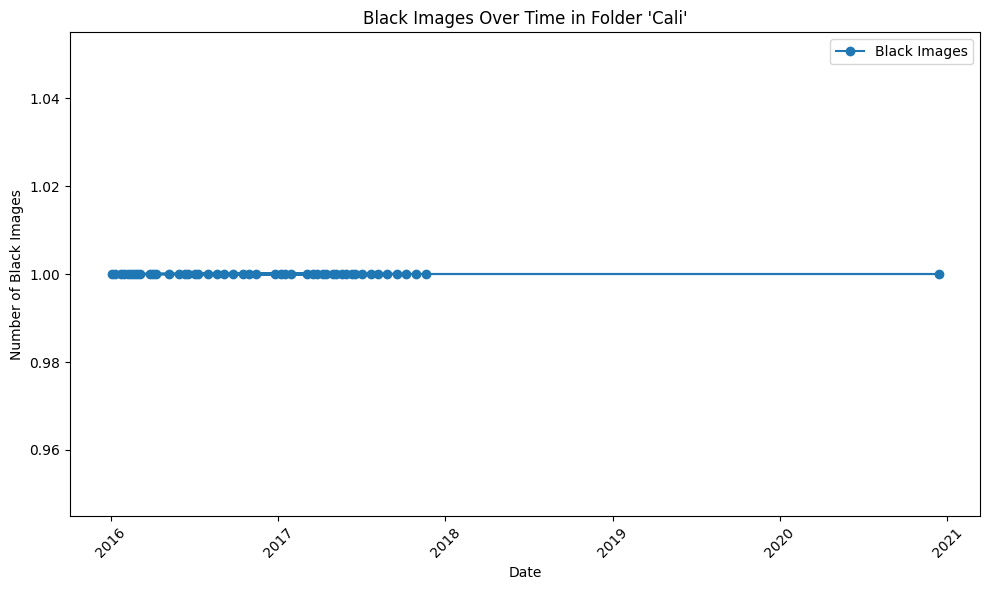

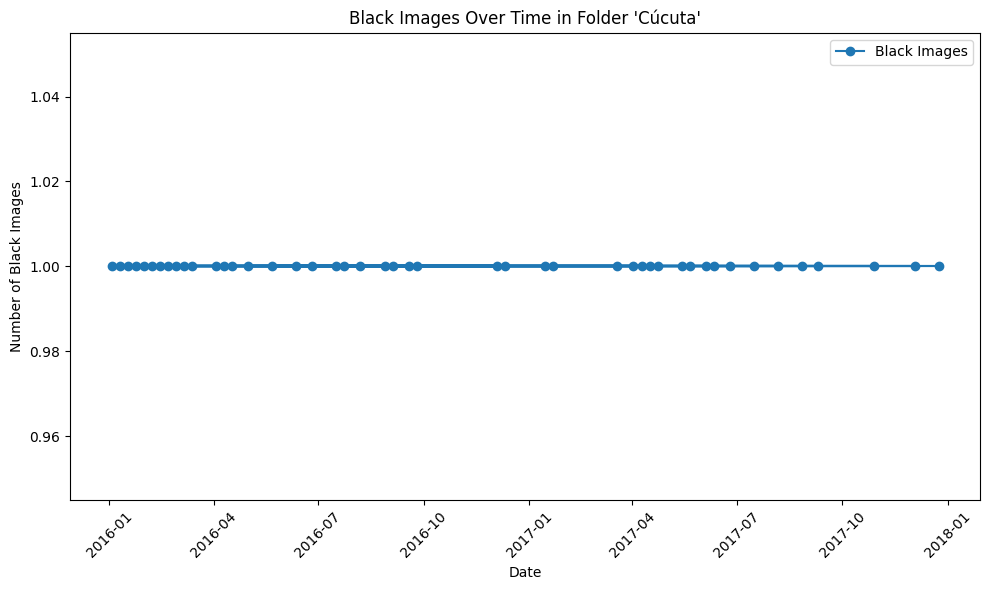

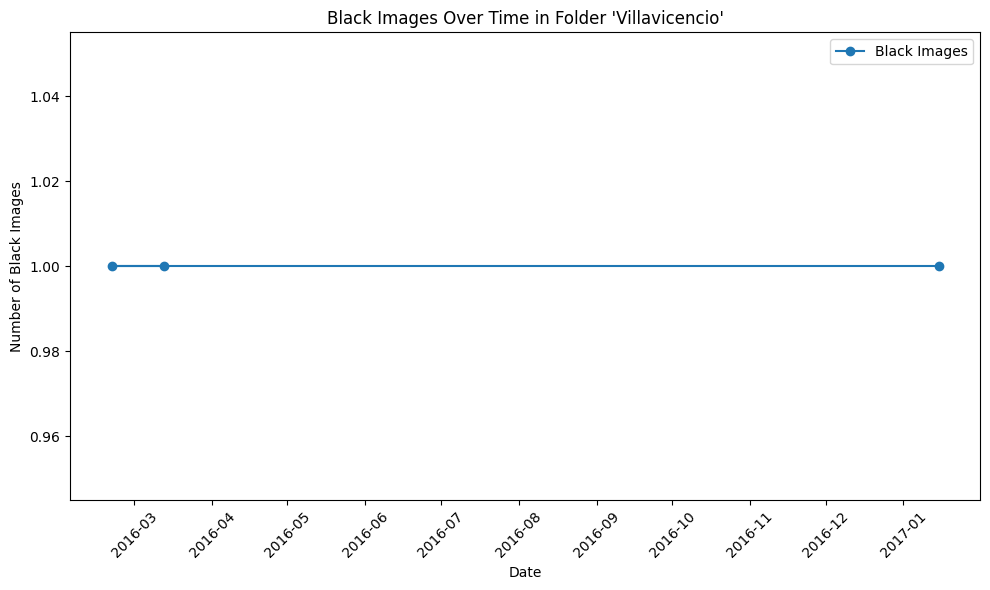

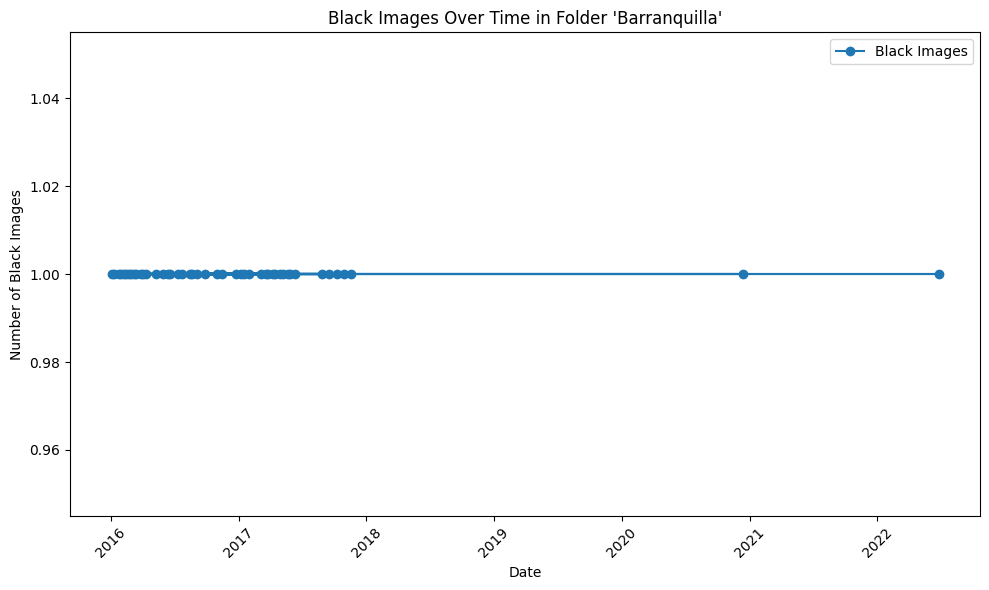

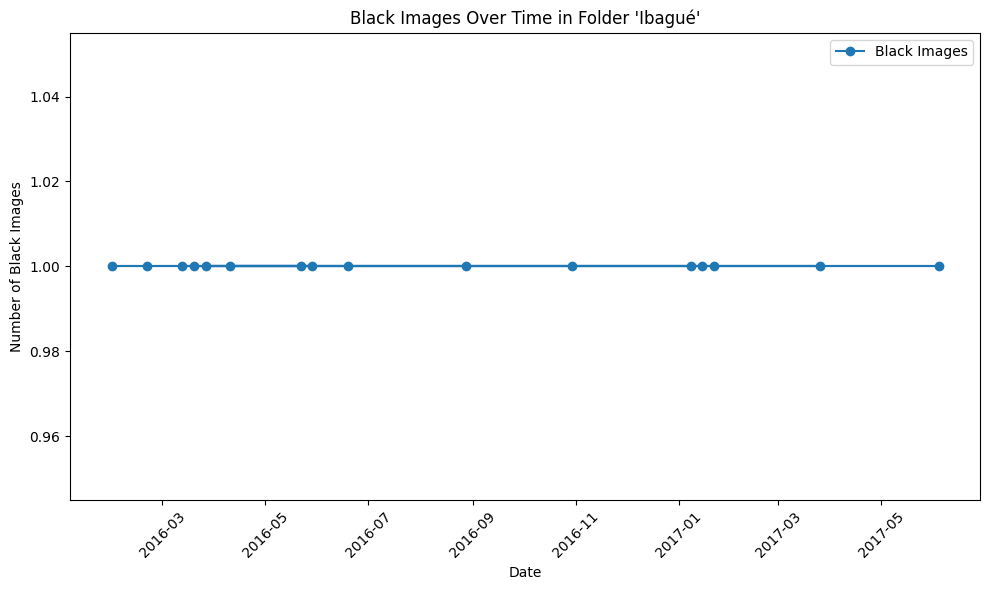

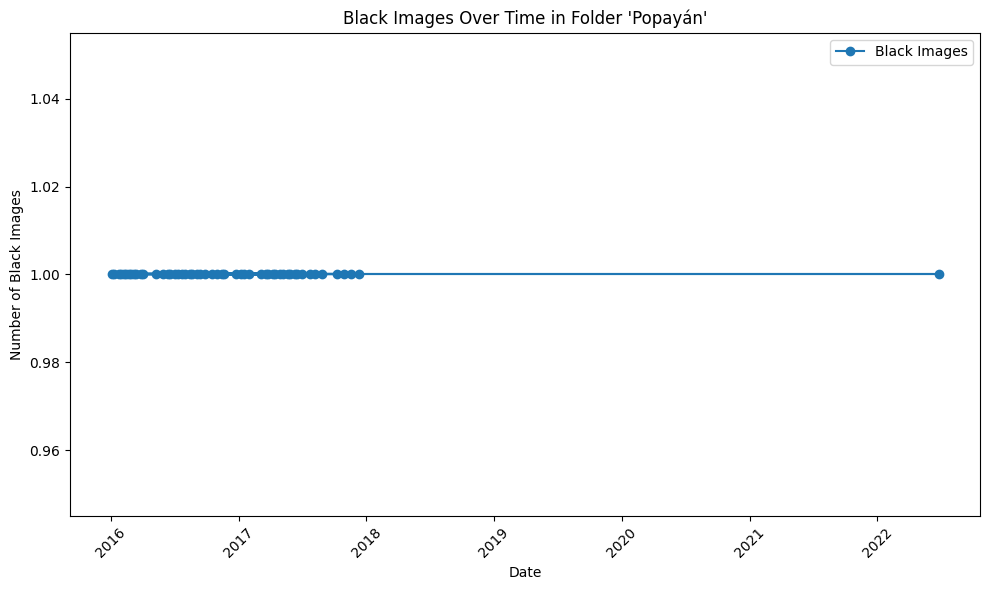

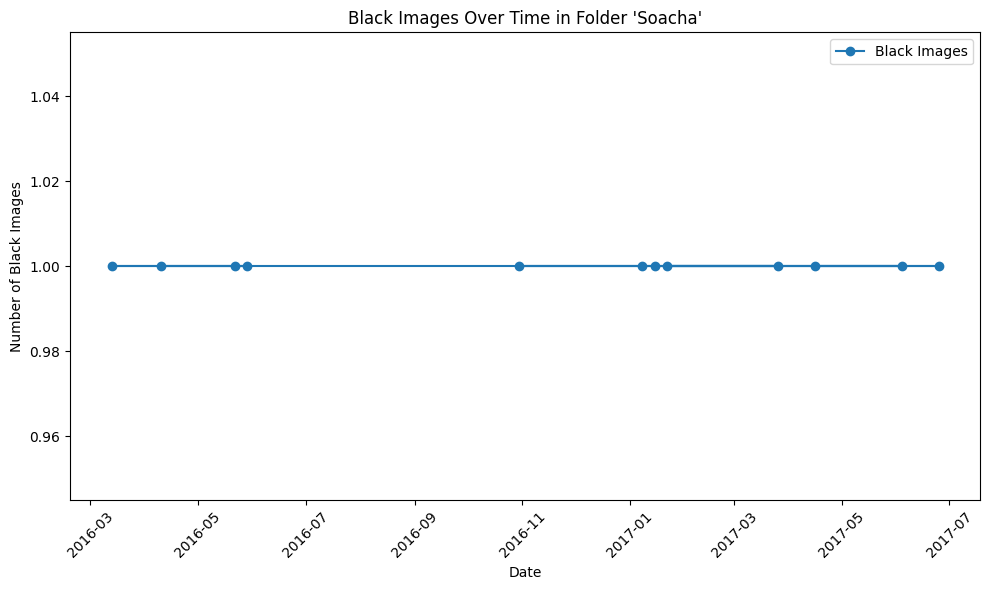

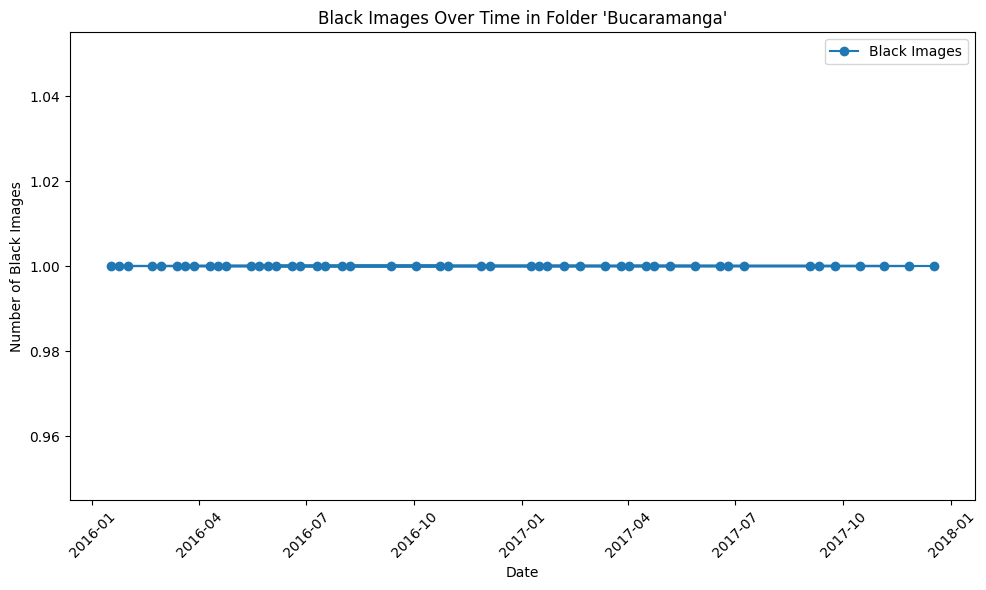

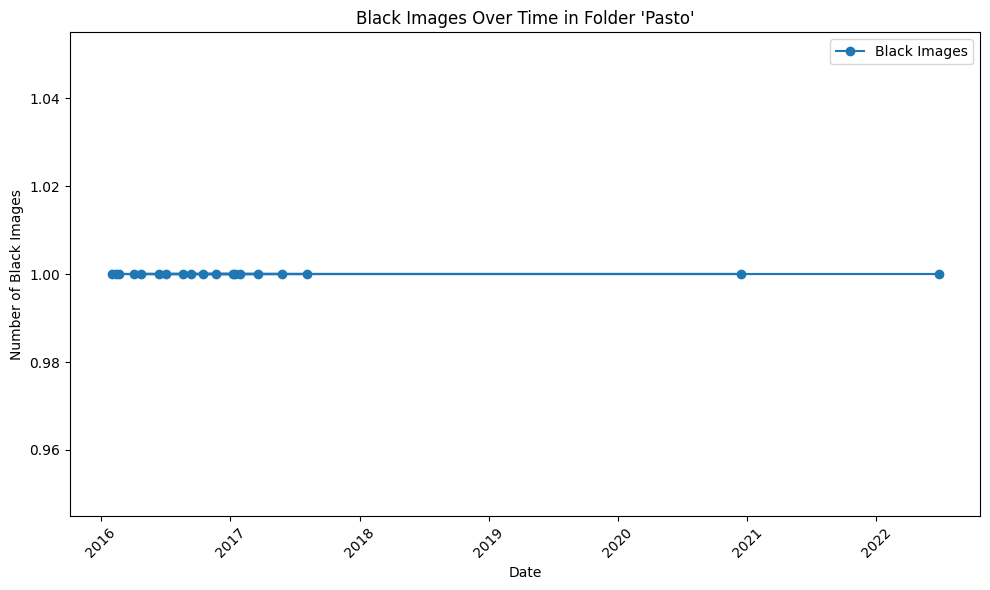

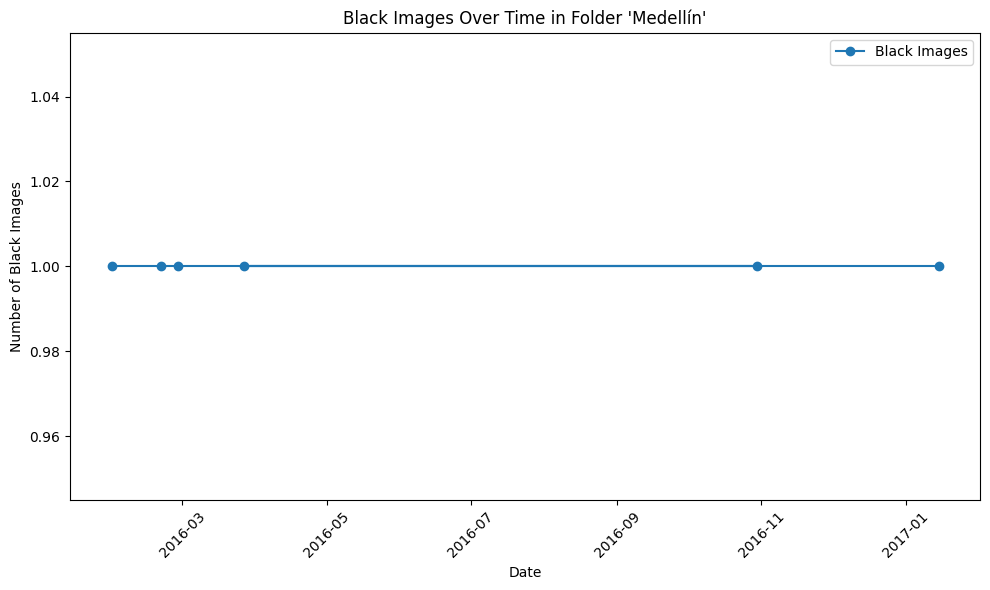

In [15]:
# Dictionary to store the black image counts per folder and date
black_image_counts = defaultdict(lambda: defaultdict(int))

# Iterate through subfolders in the DATASET directory
for folder in os.listdir(DIR):
    folder_path = os.path.join(DIR, folder)
    if os.path.isdir(folder_path):
        # Count black images in the subfolder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isdir(file_path):
                continue
            if is_mostly_black(file_path):
                # Extract the date from the image filename (assuming format: image_date.tiff)
                parts = file_name.split('_')
                if len(parts) == 2:
                    date = parts[1].split('.')[0]  # Remove the file extension
                    
                    try:
                        date = datetime.strptime(date, '%Y-%m-%d').date()
                        black_image_counts[folder][date] += 1
                    except:
                        #date = date.replace('-checkpoint', '')
                        #date = datetime.strptime(date, '%Y-%m-%d').date()
                        #black_image_counts[folder][date] += 1
                        continue

# Plot the number of black images over time per folder
for folder, date_counts in black_image_counts.items():
    dates = list(date_counts.keys())
    black_counts = list(date_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(dates, black_counts, marker='o', linestyle='-', label='Black Images')
    plt.title(f"Black Images Over Time in Folder '{folder}'")
    plt.xlabel('Date')
    plt.ylabel('Number of Black Images')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize 5 imgs per folder

In [3]:
folders = glob.glob(os.path.join(data, '*'))
pdf_pages = PdfPages(out_pdf)

def read_tiff(img_path, resize_ratio=None, resizing=True, normalize=True, printing=True):
    img = io.imread(img_path)
    img_F = img.copy()

    path_img = os.path.basename(img_path)
    if normalize:
        CHANNELS = range(12)
        img_F = np.dstack([
            skimage.exposure.rescale_intensity(img_F[:, :, c], out_range=(0, 1))
            for c in CHANNELS])
    if printing:
        print(f"(origin shape: {path_img}: {img.shape} -> rescale: {str(img_F.shape)}) - Range -> [{img_F.min(), img_F.max()}]")
    return img_F

for i, folder in enumerate(folders):
    tiff_files = glob.glob(os.path.join(folder, '*.tiff'))
    random.shuffle(tiff_files)
    selected_files = tiff_files[:10]

    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for j, tiff_file in enumerate(selected_files):
        image = read_tiff(tiff_file)
        image = np.array(image)
        image = image[:, :, 1:4]
        axes[j // 5, j % 5].imshow(image)

        folder_name = os.path.basename(folder)
        file_name = os.path.basename(tiff_file)
        title = f"{folder_name} \n{file_name}"
        axes[j // 5, j % 5].set_title(title)
        axes[j // 5, j % 5].axis('off')

    pdf_pages.savefig(fig)
    plt.close(fig)

pdf_pages.close()


(origin shape: image_2019-08-04.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2021-06-13.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2019-12-22.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2017-10-15.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2017-12-31.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2016-04-24.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2020-05-10.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2019-12-08.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2021-11-21.tiff: (509, 510, 12) -> rescale: (509, 510, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2016-05-08.tiff: (509, 510, 12) ->